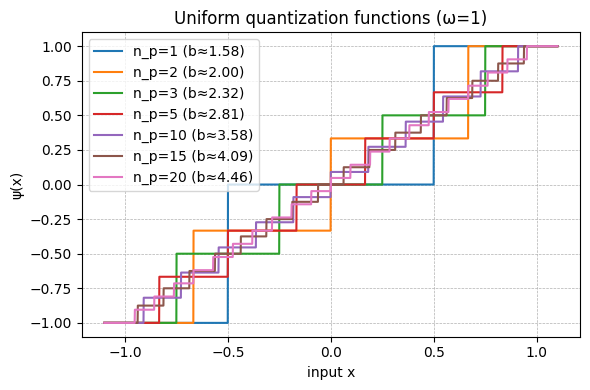

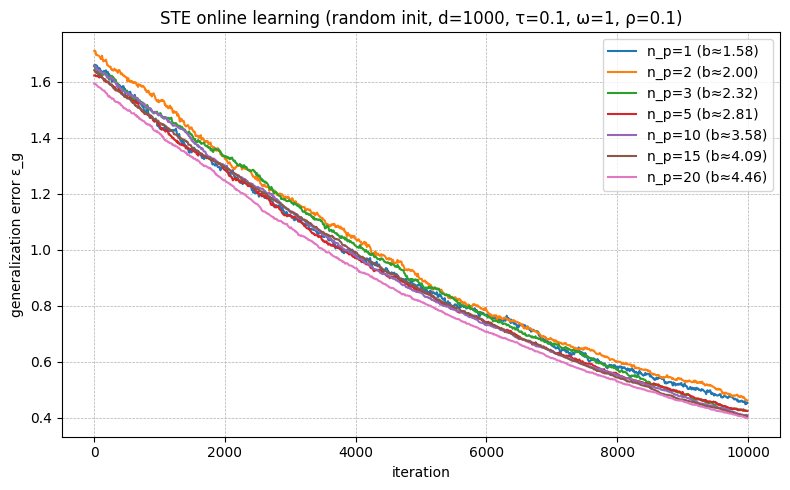

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# ===== updated full code with random initialization =====
def quantize(vec: np.ndarray, omega: float, n_p: int) -> np.ndarray:
    levels = n_p + 2
    step = 2 * omega / (levels - 1)
    clipped = np.clip(vec, -omega, omega)
    indices = np.round((clipped + omega) / step)
    return -omega + indices * step

def order_params_error(w_quant: np.ndarray, w0: np.ndarray, rho: float) -> float:
    d = w0.size
    m0 = 1.0  # (1/d)||w0||^2 = 1  (w0 = 1-vector)
    m_psi = (w_quant @ w0) / d
    q_psi = (w_quant @ w_quant) / d
    return m0 - 2 * m_psi + q_psi + rho

def run_experiment(
    d: int,
    tau: float,
    omega: float,
    rho: float,
    n_p_list: list,
    T: int = 10_000,
    record_every: int = 10,
    seed: int = 0,
):
    rng = np.random.default_rng(seed)
    w0_teacher = np.ones(d)
    results = {}
    for n_p in n_p_list:
        # --- random Gaussian initial weights ---
        w = rng.standard_normal(d)
        eps_hist, steps_hist = [], []
        for t in range(T):
            x = rng.standard_normal(d)
            noise = rng.standard_normal() * np.sqrt(rho)
            y = (w0_teacher @ x) / np.sqrt(d) + noise

            w_quant = quantize(w, omega, n_p)
            y_hat = (w_quant @ x) / np.sqrt(d)

            grad = - (y - y_hat) * x / np.sqrt(d)
            w -= tau * grad

            if t % record_every == 0:
                eps_hist.append(order_params_error(w_quant, w0_teacher, rho))
                steps_hist.append(t)

        results[n_p] = (np.array(steps_hist), np.array(eps_hist))
    return results

def plot_quant_funcs(omega: float, n_p_list: list):
    x_plot = np.linspace(-omega * 1.1, omega * 1.1, 2001)
    fig, ax = plt.subplots(figsize=(6, 4))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for idx, n_p in enumerate(n_p_list):
        ax.plot(x_plot, quantize(x_plot, omega, n_p),
                color=colors[idx % len(colors)],
                label=f"n_p={n_p} (b≈{np.log2(n_p+2):.2f})")
    ax.set_xlabel("input x")
    ax.set_ylabel("ψ(x)")
    ax.set_title(f"Uniform quantization functions (ω={omega})")
    ax.grid(True, linestyle="--", linewidth=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_epsilon(results: dict, omega: float, d: int, tau: float, rho: float):
    fig, ax = plt.subplots(figsize=(8, 5))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for idx, (n_p, (steps, eps)) in enumerate(results.items()):
        ax.plot(steps, eps,
                color=colors[idx % len(colors)],
                label=f"n_p={n_p} (b≈{np.log2(n_p+2):.2f})")
    ax.set_xlabel("iteration")
    ax.set_ylabel("generalization error ε_g")
    # ax.set_yscale("log")
    ax.set_title(f"STE online learning (random init, d={d}, τ={tau}, ω={omega}, ρ={rho})")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()

# ----- run experiment with ρ=0.001 -----
d = 1000
tau = 0.1
omega = 1
rho = 0.1
n_p_list = [1, 2, 3, 5, 10, 15, 20]
T = 10000
record_every = 10

plot_quant_funcs(omega, n_p_list)

results_random_init = run_experiment(
    d=d,
    tau=tau,
    omega=omega,
    rho=rho,
    n_p_list=n_p_list,
    T=T,
    record_every=record_every,
    seed=123
)

plot_epsilon(results_random_init, omega, d, tau, rho)


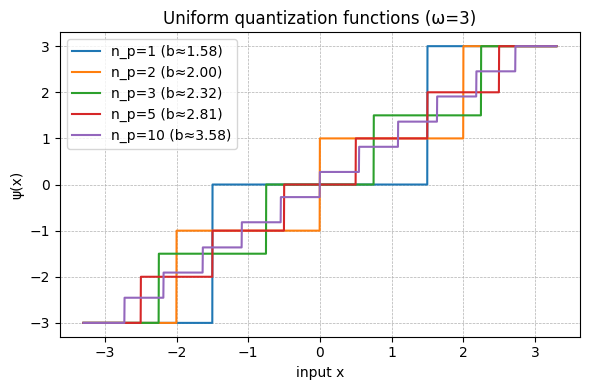

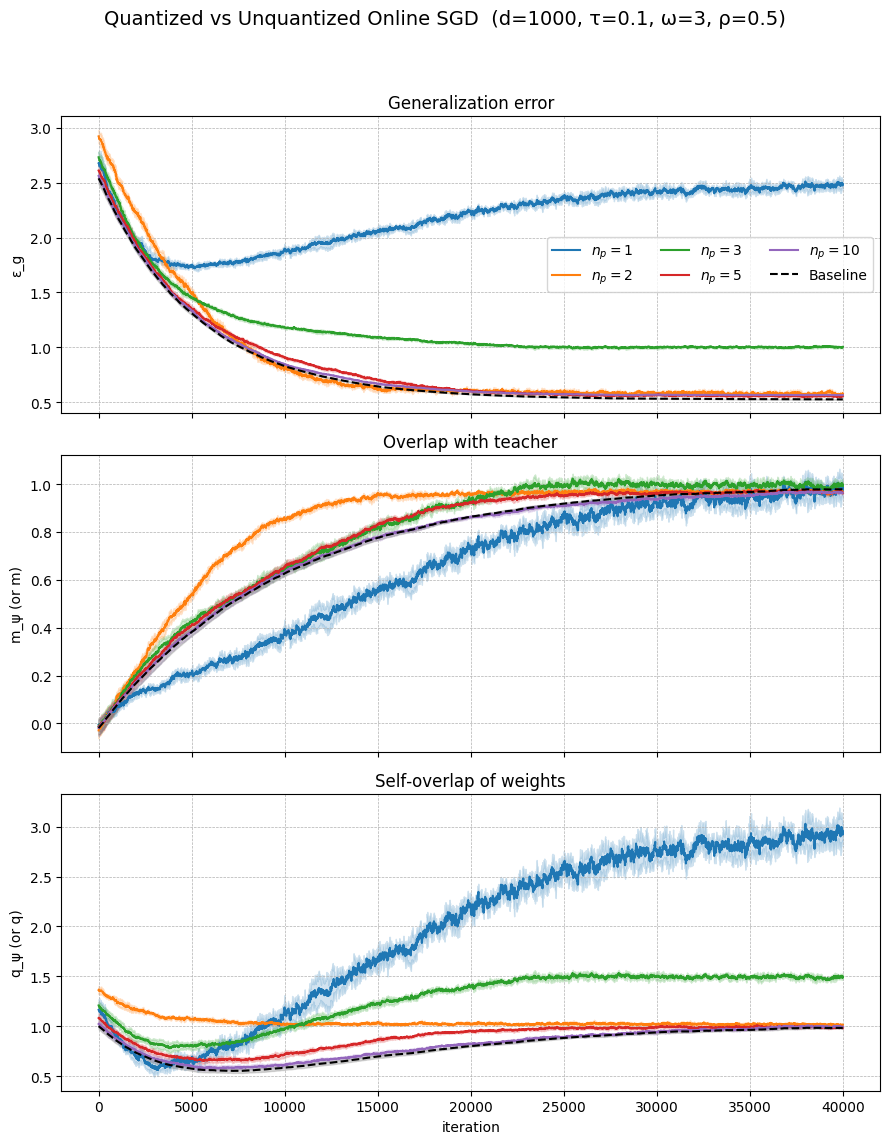

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# helper functions
# -------------------------------------------------
def quantize(vec, omega, n_p):
    """Uniform symmetric quantization with clipping to [-ω, ω]"""
    levels = n_p + 2
    step = 2 * omega / (levels - 1)
    clipped = np.clip(vec, -omega, omega)
    idx = np.round((clipped + omega) / step)
    return -omega + idx * step


def run_one(d, tau, omega, rho, n_p, T, record_every, rng, quantized=True):
    """Run a single online SGD (with or without STE) and return order‑parameter traces."""
    w0_teacher = np.ones(d)
    w = rng.standard_normal(d)

    steps, eps, m_hist, q_hist = [], [], [], []

    for t in range(T):
        x = rng.standard_normal(d)
        y = (w0_teacher @ x) / np.sqrt(d) + rng.standard_normal() * np.sqrt(rho)

        if quantized:
            w_eff = quantize(w, omega, n_p)
        else:
            w_eff = w                        # no quantization

        y_hat = (w_eff @ x) / np.sqrt(d)
        grad = - (y - y_hat) * x / np.sqrt(d)  # STE gradient coincides with true for no‑quant
        w -= tau * grad

        if t % record_every == 0:
            m = (w_eff @ w0_teacher) / d
            q = (w_eff @ w_eff) / d
            err = 1.0 - 2 * m + q + rho      # ε_g  (m0 = 1 for teacher of 1's)

            steps.append(t)
            eps.append(err)
            m_hist.append(m)
            q_hist.append(q)

    return np.array(steps), np.array(eps), np.array(m_hist), np.array(q_hist)


def run_multi_seeds(d, tau, omega, rho, n_p_list, seeds, T=10_000, record_every=10):
    """Run many seeds; return dict[n_p] = {'steps', 'mean', 'std', ...}"""
    results = {}

    for n_p in n_p_list:
        eps_all, m_all, q_all = [], [], []

        for seed in seeds:
            rng = np.random.default_rng(seed)
            steps, eps, m_hist, q_hist = run_one(
                d, tau, omega, rho, n_p, T, record_every, rng, quantized=True
            )
            eps_all.append(eps)
            m_all.append(m_hist)
            q_all.append(q_hist)

        eps_all = np.stack(eps_all)
        m_all = np.stack(m_all)
        q_all = np.stack(q_all)

        results[n_p] = {
            'steps': steps,
            'eps_mean': eps_all.mean(axis=0),
            'eps_std':  eps_all.std(axis=0),
            'm_mean':   m_all.mean(axis=0),
            'm_std':    m_all.std(axis=0),
            'q_mean':   q_all.mean(axis=0),
            'q_std':    q_all.std(axis=0),
        }
    return results


def run_baseline_seeds(d, tau, rho, seeds, T=10_000, record_every=10):
    """No quantization baseline"""
    eps_all, m_all, q_all = [], [], []

    for seed in seeds:
        rng = np.random.default_rng(seed)
        steps, eps, m_hist, q_hist = run_one(
            d, tau, omega=0, rho=rho, n_p=0, T=T,
            record_every=record_every, rng=rng, quantized=False
        )
        eps_all.append(eps)
        m_all.append(m_hist)
        q_all.append(q_hist)

    eps_all = np.stack(eps_all)
    m_all = np.stack(m_all)
    q_all = np.stack(q_all)

    return {
        'steps': steps,
        'eps_mean': eps_all.mean(axis=0),
        'eps_std':  eps_all.std(axis=0),
        'm_mean':   m_all.mean(axis=0),
        'm_std':    m_all.std(axis=0),
        'q_mean':   q_all.mean(axis=0),
        'q_std':    q_all.std(axis=0),
    }

# -------------------------------------------------
# experiment parameters
# -------------------------------------------------
d = 1000
tau = 0.1
omega = 3
rho = 0.5
n_p_list = [1, 2, 3, 5, 10]
T = 40000
record_every = 10
seeds = [0, 1, 2, 3, 4]     # five different initializations


plot_quant_funcs(omega, n_p_list)

# -------------------------------------------------
# run experiments
# -------------------------------------------------
quant_results = run_multi_seeds(d, tau, omega, rho, n_p_list, seeds, T, record_every)
baseline = run_baseline_seeds(d, tau, rho, seeds, T, record_every)

# -------------------------------------------------
# plotting
# -------------------------------------------------
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axes = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

# --- ε_g ---
ax = axes[0]
for idx, n_p in enumerate(n_p_list):
    r = quant_results[n_p]
    ax.plot(r['steps'], r['eps_mean'], color=colors[idx % len(colors)],
            label=fr"$n_p=${n_p}")
    ax.fill_between(r['steps'],
                    r['eps_mean'] - r['eps_std'],
                    r['eps_mean'] + r['eps_std'],
                    color=colors[idx % len(colors)], alpha=0.2)
# baseline
ax.plot(baseline['steps'], baseline['eps_mean'], color='black', linestyle='--', label='Baseline')
ax.fill_between(baseline['steps'],
                baseline['eps_mean'] - baseline['eps_std'],
                baseline['eps_mean'] + baseline['eps_std'],
                color='gray', alpha=0.3)
ax.set_ylabel("ε_g")
# ax.set_yscale("log")
ax.set_title("Generalization error")
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(ncol=3)

# --- m_ψ ---
ax = axes[1]
for idx, n_p in enumerate(n_p_list):
    r = quant_results[n_p]
    ax.plot(r['steps'], r['m_mean'], color=colors[idx % len(colors)])
    ax.fill_between(r['steps'],
                    r['m_mean'] - r['m_std'],
                    r['m_mean'] + r['m_std'],
                    color=colors[idx % len(colors)], alpha=0.2)
ax.plot(baseline['steps'], baseline['m_mean'], color='black', linestyle='--')
ax.fill_between(baseline['steps'],
                baseline['m_mean'] - baseline['m_std'],
                baseline['m_mean'] + baseline['m_std'],
                color='gray', alpha=0.3)
ax.set_ylabel("m_ψ (or m)")
ax.set_title("Overlap with teacher")
ax.grid(True, linestyle='--', linewidth=0.5)

# --- q_ψ ---
ax = axes[2]
for idx, n_p in enumerate(n_p_list):
    r = quant_results[n_p]
    ax.plot(r['steps'], r['q_mean'], color=colors[idx % len(colors)])
    ax.fill_between(r['steps'],
                    r['q_mean'] - r['q_std'],
                    r['q_mean'] + r['q_std'],
                    color=colors[idx % len(colors)], alpha=0.2)
ax.plot(baseline['steps'], baseline['q_mean'], color='black', linestyle='--')
ax.fill_between(baseline['steps'],
                baseline['q_mean'] - baseline['q_std'],
                baseline['q_mean'] + baseline['q_std'],
                color='gray', alpha=0.3)
ax.set_ylabel("q_ψ (or q)")
ax.set_xlabel("iteration")
ax.set_title("Self‑overlap of weights")
ax.grid(True, linestyle='--', linewidth=0.5)

plt.suptitle(f"Quantized vs Unquantized Online SGD  (d={d}, τ={tau}, ω={omega}, ρ={rho})",
            fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## 等方性の仮定の数値検証

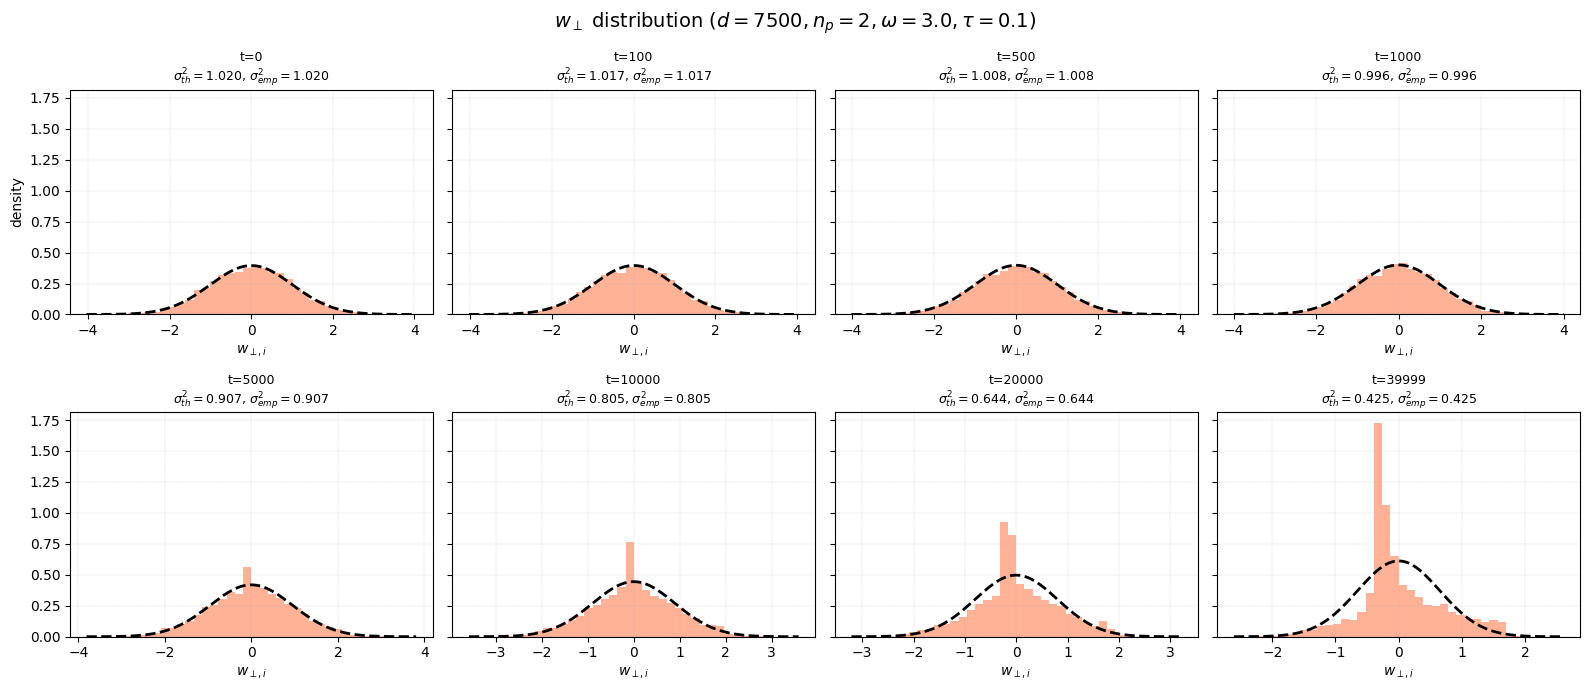

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
d = 7500
tau = 0.1
omega = 3.0
rho = 0.1
n_p = 2
T = 40000
check_steps = [0, 100, 500, 1000, 5000, 10000, 20000, 39999]

def quantize(vec, omega, n_p):
    levels = n_p + 2
    step = 2 * omega / (levels - 1)
    clipped = np.clip(vec, -omega, omega)
    idx = np.round((clipped + omega) / step)
    return -omega + idx * step

# simulate
rng = np.random.default_rng(2026)
w0 = np.ones(d)
w = rng.standard_normal(d)
snapshots = {}

for t in range(T + 1):
    if t in check_steps:
        snapshots[t] = w.copy()
    if t == T:
        break
    x = rng.standard_normal(d)
    noise = rng.standard_normal() * np.sqrt(rho)
    y = (w0 @ x) / np.sqrt(d) + noise
    wq = quantize(w, omega, n_p)
    y_hat = (wq @ x) / np.sqrt(d)
    grad = -(y - y_hat) * x / np.sqrt(d)
    w -= tau * grad

# plotting
rows, cols = 2, 4
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3.5*rows), sharey=True)
axes = axes.flatten()

for ax, t in zip(axes, check_steps):
    w_t = snapshots[t]
    m = (w_t @ w0) / d
    q = (w_t @ w_t) / d
    sigma2_th = q - m**2
    w_perp = w_t - m * w0
    sigma2_emp = w_perp.var()
    
    bins = np.linspace(-4*np.sqrt(sigma2_th), 4*np.sqrt(sigma2_th), 41)
    ax.hist(w_perp, bins=bins, density=True, alpha=0.6, color='coral')
    x_plot = np.linspace(bins[0], bins[-1], 400)
    ax.plot(x_plot, norm.pdf(x_plot, 0, np.sqrt(sigma2_th)), 'k--', lw=2)
    
    ax.set_title(f"t={t}\n$\\sigma^2_{{th}}={sigma2_th:.3f}$, "
                 f"$\\sigma^2_{{emp}}={sigma2_emp:.3f}$", fontsize=9)
    ax.set_xlabel("$w_{\\perp,i}$")
    ax.grid(True, linestyle="--", linewidth=0.3, alpha=0.6)

axes[0].set_ylabel("density")
fig.suptitle(rf"$w_\perp$ distribution ($d={d}, n_p={n_p}, \omega={omega}, \tau={tau}$)", fontsize=14)
plt.tight_layout()


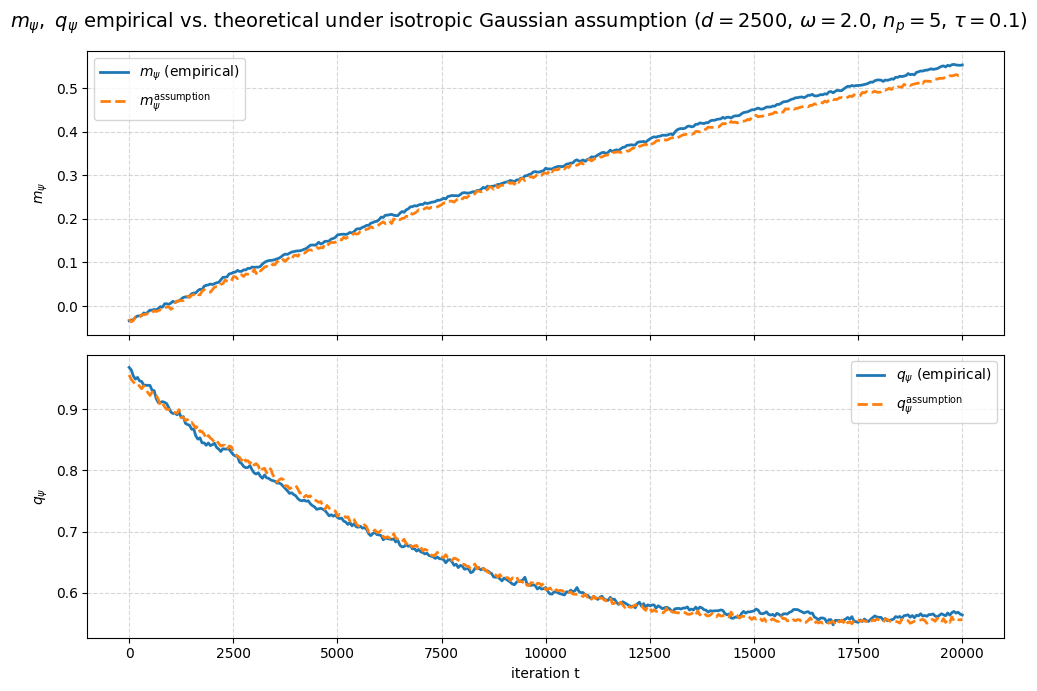

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ----- Parameters -----
d = 2500
tau = 0.1
omega = 2.0
rho = 0.05
n_p = 5
T = 20000
record_every = 50
n_samples = 100_000  # for theoretical expectation

# ----- Quantization -----
def quantize(vec, omega, n_p):
    levels = n_p + 2
    step = 2 * omega / (levels - 1)
    clipped = np.clip(vec, -omega, omega)
    idx = np.round((clipped + omega) / step)
    return -omega + idx * step

def get_quant_func(omega, n_p):
    levels = n_p + 2
    step = 2 * omega / (levels - 1)
    def quant(x):
        clipped = np.clip(x, -omega, omega)
        idx = np.round((clipped + omega) / step)
        return -omega + idx * step
    return quant

quant_func = get_quant_func(omega, n_p)

# ----- Theoretical expressions using isotropic Gaussian assumption -----
def m_psi_theory(m, q, m0, quant_func, n_samples):
    sigma = np.sqrt(q - (m ** 2) / m0 ** 2)
    z = np.random.normal(0, 1, size=n_samples)
    inputs = (m / m0) + sigma * z
    return np.mean(quant_func(inputs))

def q_psi_theory(m, q, m0, quant_func, n_samples):
    sigma = np.sqrt(q - (m ** 2) / m0 ** 2)
    z = np.random.normal(0, 1, size=n_samples)
    inputs = (m / m0) + sigma * z
    return np.mean(quant_func(inputs) ** 2)

# ----- Initialization -----
rng = np.random.default_rng(2028)
w0 = np.ones(d)
w = rng.standard_normal(d)

# ----- Storage -----
steps = []
m_psi_empirical = []
q_psi_empirical = []
m_psi_theoretical = []
q_psi_theoretical = []

# ----- Online learning loop -----
for t in range(T + 1):
    x = rng.standard_normal(d)
    noise = rng.standard_normal() * np.sqrt(rho)
    y = (w0 @ x) / np.sqrt(d) + noise
    wq = quantize(w, omega, n_p)
    y_hat = (wq @ x) / np.sqrt(d)
    grad = -(y - y_hat) * x / np.sqrt(d)
    w -= tau * grad

    if t % record_every == 0:
        m = (w @ w0) / d
        q = (w @ w) / d
        wq = quantize(w, omega, n_p)
        mpsi = (wq @ w0) / d
        qpsi = (wq @ wq) / d
        mpsi_th = m_psi_theory(m, q, m0=1.0, quant_func=quant_func, n_samples=n_samples)
        qpsi_th = q_psi_theory(m, q, m0=1.0, quant_func=quant_func, n_samples=n_samples)

        steps.append(t)
        m_psi_empirical.append(mpsi)
        q_psi_empirical.append(qpsi)
        m_psi_theoretical.append(mpsi_th)
        q_psi_theoretical.append(qpsi_th)

# ----- Plotting -----
fig, axs = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

axs[0].plot(steps, m_psi_empirical, label=r"$m_\psi$ (empirical)", lw=2)
axs[0].plot(steps, m_psi_theoretical, '--', label=r"$m_\psi^{\mathrm{assumption}}$", lw=2)
axs[0].set_ylabel(r"$m_\psi$")
axs[0].grid(True, linestyle='--', alpha=0.5)
axs[0].legend()

axs[1].plot(steps, q_psi_empirical, label=r"$q_\psi$ (empirical)", lw=2)
axs[1].plot(steps, q_psi_theoretical, '--', label=r"$q_\psi^{\mathrm{assumption}}$", lw=2)
axs[1].set_ylabel(r"$q_\psi$")
axs[1].set_xlabel("iteration t")
axs[1].grid(True, linestyle='--', alpha=0.5)
axs[1].legend()

fig.suptitle(
    rf"$m_\psi,\ q_\psi$ empirical vs. theoretical under isotropic Gaussian assumption "
    rf"($d={d}$, $\omega={omega}$, $n_p={n_p}$, $\tau={tau}$)", 
    fontsize=14
)
plt.tight_layout()
plt.show()


Text(0.5, 0.98, 'STE Simulation vs. Theory  ($d=500,\\; \\omega=2.0,\\; n_p=1,\\; \tau=0.1$)')

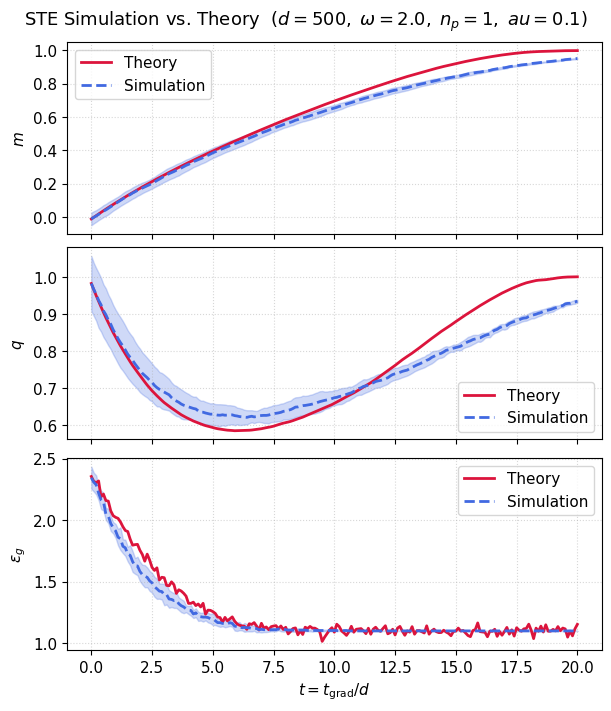

In [19]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
plt.rcParams.update({'font.size':11})

# Parameters
d,tau,omega,n_p,rho,lam = 500,0.1,2.0,1,0.1,0.0
T_grad,rec,mc_n,n_runs = 10000,50,10000,5
m0, step = 1.0, 2*omega/(n_p+1)

# Fast quantizer
def quantize_array(a):
    idx=np.rint((np.clip(a,-omega,omega)+omega)/step)
    return -omega + idx*step

def psi_scalar(x):
    return -omega + np.rint((np.clip(x,-omega,omega)+omega)/step)*step

# Monte Carlo expectation
def mc_expect(m,q):
    sig2=q-m**2
    z=m+np.sqrt(max(sig2,0))*np.random.randn(mc_n)
    p=psi_scalar(z)
    return p.mean(),(p**2).mean(),(z*p).mean()

def rhs(t,y):
    m,q=y
    e1,e2,e3=mc_expect(m,q)
    dm=-tau*((1+lam)*e1-1)
    dq=-2*tau*((1+lam)*e3-m)+tau**2*(m0-2*e1+e2+rho)
    return dm,dq

# --- Simulation over multiple runs ---
t_grads=np.arange(0,T_grad+1,rec)
t_axis=t_grads/d
M_runs,Q_runs,E_runs=[],[],[]

for seed in range(n_runs):
    rng=np.random.default_rng(seed)
    w=rng.standard_normal(d)
    m_track,q_track,e_track=[],[],[]
    for t_grad in range(T_grad+1):
        if t_grad%rec==0:
            m=(w@np.ones(d))/d; q=(w@w)/d; wq=quantize_array(w)
            e=m0 - 2*(wq@np.ones(d))/d + (wq@wq)/d + rho
            m_track.append(m); q_track.append(q); e_track.append(e)
        x=rng.standard_normal(d)
        y=(np.ones(d)@x)/np.sqrt(d)+rng.normal(scale=np.sqrt(rho))
        wq=quantize_array(w)
        y_hat=(wq@x)/np.sqrt(d)
        w-=tau*-(y-y_hat)*x/np.sqrt(d)
    M_runs.append(m_track); Q_runs.append(q_track); E_runs.append(e_track)

M_runs,Q_runs,E_runs=map(np.array,(M_runs,Q_runs,E_runs))
m_mean,m_std=M_runs.mean(0),M_runs.std(0)
q_mean,q_std=Q_runs.mean(0),Q_runs.std(0)
e_mean,e_std=E_runs.mean(0),E_runs.std(0)

# --- ODE solve ---
sol=solve_ivp(rhs,[0,T_grad/d],[m_mean[0],q_mean[0]],t_eval=t_axis,rtol=1e-4,atol=1e-7)
m_th,q_th=sol.y
e_th=[m0-2*mc_expect(m,q)[0]+mc_expect(m,q)[1]+rho for m,q in zip(m_th,q_th)]

# --- Plot ----------
fig,axes=plt.subplots(3,1,figsize=(6,7),sharex=True,constrained_layout=True)
def add_panel(ax,mean,std,theory,label):
    ax.plot(t_axis,theory,color='crimson',lw=2,label='Theory')
    ax.plot(t_axis,mean,color='royalblue',ls='--',lw=2,label='Simulation')
    ax.fill_between(t_axis,mean-std,mean+std,color='royalblue',alpha=0.25)
    ax.set_ylabel(label)
    ax.grid(True,ls=':',alpha=.5)
    ax.legend()

add_panel(axes[0],m_mean,m_std,m_th,r'$m$')
add_panel(axes[1],q_mean,q_std,q_th,r'$q$')
add_panel(axes[2],e_mean,e_std,e_th,r'$\varepsilon_g$')
axes[2].set_xlabel(r'$t = t_{\mathrm{grad}}/d$')

fig.suptitle(fr'STE Simulation vs. Theory  '
             f'($d={d},\; \omega={omega},\; n_p={n_p},\; \tau={tau}$)',fontsize=13)



Text(0.5, 0.98, 'STE Simulation (shaded) vs Theory (solid) for berbagai $n_p$\n($d=500,\\; \\omega=2.0,\\; \tau=0.1$)')

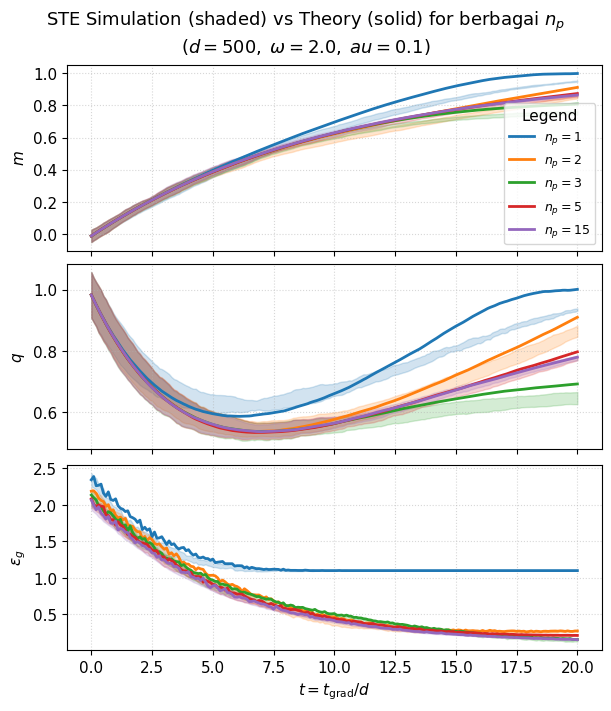

In [ ]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
plt.rcParams.update({'font.size':11})

# Fixed parameters
d,tau,omega,rho,lam = 500,0.1,2.0,0.1,0.0
T_grad,rec,mc_n,n_runs = 10000,50,5000,5   # mc_n smaller for speed
m0=1.0
n_p_list=[1,2,3,5,15]
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']

t_grads=np.arange(0,T_grad+1,rec)
t_axis=t_grads/d

def quantize_np(arr,step):
    return -omega + np.rint((np.clip(arr,-omega,omega)+omega)/step)*step

# containers
theory={'m':[],'q':[],'e':[]}
sim_mean={'m':[],'q':[],'e':[]}
sim_std={'m':[],'q':[],'e':[]}

for n_p in n_p_list:
    step = 2*omega/(n_p+1)
    # fast psi on array
    def psi_arr(z): return -omega + np.rint((np.clip(z,-omega,omega)+omega)/step)*step
    
    # Monte Carlo expectation
    def mc_expect(m,q):
        sig2=q-m**2
        z = m + np.sqrt(max(sig2,0))*np.random.randn(mc_n)
        p = psi_arr(z)
        return p.mean(), (p**2).mean(), (z*p).mean()
    
    def rhs(t,y):
        m,q=y
        e1,e2,e3=mc_expect(m,q)
        dm=-tau*((1+lam)*e1-1)
        dq=-2*tau*((1+lam)*e3 - m)+tau**2*(m0-2*e1+e2+rho)
        return dm,dq
    
    # multi‑run simulation
    M_runs=np.zeros((n_runs,len(t_axis)))
    Q_runs=np.zeros_like(M_runs)
    E_runs=np.zeros_like(M_runs)
    
    for run in range(n_runs):
        rng=np.random.default_rng(run)
        w=rng.standard_normal(d)
        idx=0
        for t_grad in range(T_grad+1):
            if t_grad%rec==0:
                wq=quantize_np(w,step)
                m=(w@np.ones(d))/d
                q=(w@w)/d
                eps=m0 - 2*(wq@np.ones(d))/d + (wq@wq)/d + rho
                M_runs[run,idx]=m; Q_runs[run,idx]=q; E_runs[run,idx]=eps
                idx+=1
            x=rng.standard_normal(d)
            y=(np.ones(d)@x)/np.sqrt(d)+rng.normal(scale=np.sqrt(rho))
            wq=quantize_np(w,step)
            y_hat=(wq@x)/np.sqrt(d)
            w -= tau*-(y-y_hat)*x/np.sqrt(d)
    
    m_mean=M_runs.mean(0); m_std=M_runs.std(0)
    q_mean=Q_runs.mean(0); q_std=Q_runs.std(0)
    e_mean=E_runs.mean(0); e_std=E_runs.std(0)
    
    sol=solve_ivp(rhs,[0,T_grad/d],[m_mean[0],q_mean[0]],t_eval=t_axis,rtol=1e-4,atol=1e-7)
    m_th,q_th=sol.y
    e_th=[]
    for m,q in zip(m_th,q_th):
        e1,e2,_=mc_expect(m,q)
        e_th.append(m0-2*e1+e2+rho)
    e_th=np.array(e_th)
    
    for key,data in zip(['m','q','e'],[m_th,q_th,e_th]):
        theory[key].append(data)
    for key,mean,std in zip(['m','q','e'],[m_mean,q_mean,e_mean],[m_std,q_std,e_std]):
        sim_mean[key].append(mean); sim_std[key].append(std)

# plotting
fig,axes=plt.subplots(3,1,figsize=(6,7),sharex=True,constrained_layout=True)
labels=[f'$n_p={n}$' for n in n_p_list]

for idx,(col,lab) in enumerate(zip(colors,labels)):
    axes[0].plot(t_axis,theory['m'][idx],color=col,lw=2,label=lab)
    axes[0].fill_between(t_axis,sim_mean['m'][idx]-sim_std['m'][idx],
                                   sim_mean['m'][idx]+sim_std['m'][idx],
                                   color=col,alpha=0.2)
    axes[1].plot(t_axis,theory['q'][idx],color=col,lw=2)
    axes[1].fill_between(t_axis,sim_mean['q'][idx]-sim_std['q'][idx],
                                   sim_mean['q'][idx]+sim_std['q'][idx],
                                   color=col,alpha=0.2)
    axes[2].plot(t_axis,theory['e'][idx],color=col,lw=2)
    axes[2].fill_between(t_axis,sim_mean['e'][idx]-sim_std['e'][idx],
                                   sim_mean['e'][idx]+sim_std['e'][idx],
                                   color=col,alpha=0.2)

for ax,ylabel in zip(axes,[r'$m$',r'$q$',r'$\varepsilon_g$']):
    ax.set_ylabel(ylabel)
    ax.grid(ls=':',alpha=.5)

axes[2].set_xlabel(r'$t=t_{\mathrm{grad}}/d$')
axes[0].legend(title='Legend',fontsize=9)

fig.suptitle(fr'STE Simulation (shaded) vs Theory (solid) for $n_p$'
             rf'\n($d={d},\; \omega={omega},\; \tau={tau}$)',fontsize=13)



In [22]:
# 論文用の体裁
plt.rcParams['font.family'] ='sans-serif'
plt.rcParams['font.size'] = 12
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.xmargin'] = 0.01
plt.rcParams['axes.ymargin'] = 0.01
plt.rcParams["legend.fancybox"] = False  
plt.rcParams["legend.framealpha"] = 1 
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams["mathtext.fontset"] = "stix"
# 以下の順番で使用する
line_styles_list = ['-', '--', '-.', ':']
makers_list = ['o', 's', '^', 'D', 'v', '<', '>', '1', '2', '3']
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

In [53]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


# fixed hyper‑parameters
d,tau,omega,rho,lam = 200,0.05,2.0,0.01,0.0
T_grad,rec,mc_n,n_runs = 20000,100,200000,5
m0 = 1.0
n_p_list=[1,2,3,4,5,10,15]
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
t_grads=np.arange(0,T_grad+1,rec)
t_axis=t_grads/d

def run_case(n_p,seed_base=0):
    step=2*omega/(n_p+1)
    def psi_scalar(x): return -omega+np.rint((np.clip(x,-omega,omega)+omega)/step)*step
    def quantize_vec(a): return psi_scalar(a)
    def mc_expect(m,q):
        sig2=q-m**2
        z=m+np.sqrt(max(sig2,0))*np.random.randn(mc_n)
        p=psi_scalar(z)
        return p.mean(),(p**2).mean(),(z*p).mean()
    def rhs(t,y):
        m,q=y
        e1,e2,_=mc_expect(m,q)
        dm=-tau*((1+lam)*e1-1)
        dq=-2*tau*((1+lam)*(_:=mc_expect(m,q)[2]) - m)+tau**2*(m0-2*e1+e2+rho)
        return dm,dq

    # simulation multiple runs
    E_runs=[]
    for run in range(n_runs):
        rng=np.random.default_rng(seed_base+run)
        w=rng.standard_normal(d)
        e_track=[]
        for t_grad in range(T_grad+1):
            if t_grad%rec==0:
                wq=quantize_vec(w)
                eps=m0-2*(wq@np.ones(d))/d+(wq@wq)/d+rho
                e_track.append(eps)
            x=rng.standard_normal(d)
            y=(np.ones(d)@x)/np.sqrt(d)+rng.normal(scale=np.sqrt(rho))
            wq=quantize_vec(w)
            y_hat=(wq@x)/np.sqrt(d)
            w-=tau*-(y-y_hat)*x/np.sqrt(d)
        E_runs.append(e_track)
    E_runs=np.array(E_runs)
    e_mean,e_std=E_runs.mean(0),E_runs.std(0)

    # theory
    # need initial m,q from first run
    w_init = np.random.default_rng(seed_base).standard_normal(d)  # same dist
    m_init=(w_init@np.ones(d))/d
    q_init=(w_init@w_init)/d
    sol=solve_ivp(rhs,[0,T_grad/d],[m_init,q_init],t_eval=t_axis,rtol=1e-4,atol=1e-7)
    m_th,q_th=sol.y
    e_th=[]
    for m,q in zip(m_th,q_th):
        e1,e2,_=mc_expect(m,q)
        e_th.append(m0-2*e1+e2+rho)
    return np.array(e_th), e_mean, e_std

# run all n_p
theory_list=[]; mean_list=[]; std_list=[]
for n_p in n_p_list:
    e_th,e_mean,e_std=run_case(n_p,seed_base=100*n_p)
    theory_list.append(e_th); mean_list.append(e_mean); std_list.append(e_std)


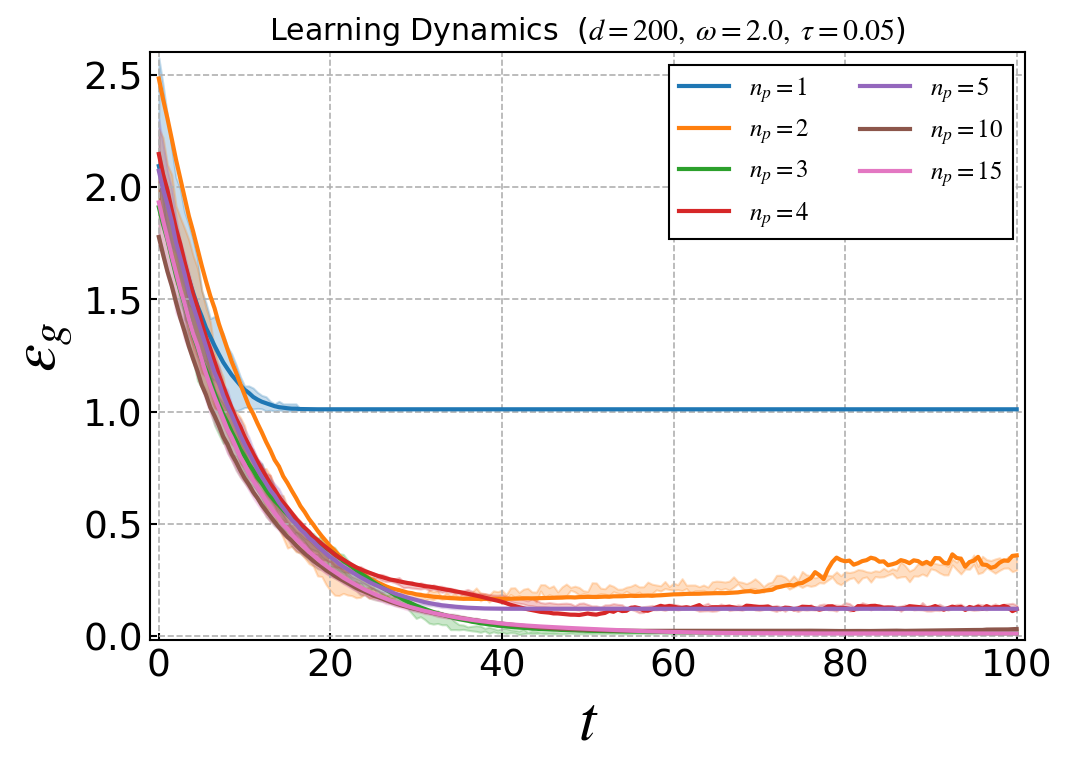

In [54]:
# ----------- plot -------------
fig,ax=plt.subplots(figsize=(7,5),constrained_layout=True, dpi=150)
for idx,(col,n_p) in enumerate(zip(colors,n_p_list)):
    ax.plot(t_axis,theory_list[idx],color=color_list[idx],lw=2,label=f'$n_p={n_p}$')
    ax.fill_between(t_axis,mean_list[idx]-std_list[idx],mean_list[idx]+std_list[idx],
                    color=color_list[idx],alpha=0.25)

ax.set_xlabel(r'$t$', fontsize=30)
ax.set_ylabel(r'$\varepsilon_g$', fontsize=30)
ax.grid(ls='--')
ax.tick_params(axis='both', which='major', labelsize=18)
ax.legend(fontsize=12, ncol=2)
ax.set_title(fr'Learning Dynamics  ($d={d},\;\omega={omega},\;\tau={tau}$)')
plt.show()
